In [3]:
!pip install pandas fiona shapely pyproj rtree 
!pip install contextily
!pip install geopandas
!pip install topojson
!pip install openpyxl



In [4]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
#### On importe le fichier répertoriant les installations industrielles rejetant des polluants

import requests

# Téléchargement du fichier avec la localisation des installations industrielles rejetant des polluants, directement depuis le site Géorisques
url_industries_polluantes = "https://files.georisques.fr/irep/2023.zip"
response_industries_polluantes = requests.get(url_industries_polluantes)

# Enregistrement du fichier localement
with open("Industries_polluantes.xlsx", "wb") as f:
    f.write(response_industries_polluantes.content)



In [6]:

import pandas as pd
import zipfile

with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/etablissements.csv") as f:
        industries_polluantes = pd.read_csv(f, sep=None, engine='python')

industries_polluantes.head()




,identifiant,nom_etablissement,numero_siret,adresse,code_postal,code_insee,commune,code_departement,departement,code_region,region,coordonnees_x,coordonnees_y,code_epsg,code_ape,libelle_ape,code_eprtr,libelle_eprtr
0,6101975,COFIBEX,43425026200012,AVENUE DE LA LIBERATION ZONE INDUSTRIELLE,1500,01004,AMBERIEU-EN-BUGEY,01,AIN,84.0,AUVERGNE-RHONE-ALPES,5.33551,45.96163,4326.0,6420Z,Activités des sociétés holding,NaN,NaN
1,9000321,AIA Ambrieu en Bugey,15000028900135,avenue du colonel CHAMBONNET Base arienne 278,1508,01004,AMBERIEU-EN-BUGEY,01,AIN,84.0,AUVERGNE-RHONE-ALPES,5.34592,45.97117,4326.0,8422Z,Défense,NaN,NaN
2,6100021,THIERRY DANNENMULLER TRANSPORTS LOCATIONS TRAV...,35234119200065,LE PELOUX CARRIERE D'AMBRONAY LE PELOUX,1500,01007,AMBRONAY,01,AIN,84.0,AUVERGNE-RHONE-ALPES,5.34282,46.02817,4326.0,0811Z,Extraction de pierres ornementales et de const...,NaN,NaN
3,3202489,SOCIETE BRESSANE DE STOCKAGE ET DE CHARGEMENT,34408383700015,GARE,1500,01007,AMBRONAY,01,AIN,84.0,AUVERGNE-RHONE-ALPES,5.35873,46.00535,4326.0,5224B,Manutention non portuaire,NaN,NaN
4,6101980,FERROGLOBE FRANCE,64200517700265,ROUTE DE LA GARE,1350,01010,ANGLEFORT,01,AIN,84.0,AUVERGNE-RHONE-ALPES,5.81144,45.90610,4326.0,2410Z,Sidérurgie,2.(e).(i),destinées à la production de métaux bruts non ...


In [7]:
#### Et on importe le fichier avec les shapefiles des communes

# Téléchargement du fichier avec les shapefiles des communes, directement depuis Datagouv
url_communes = "https://www.data.gouv.fr/api/1/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
zip_communes = "shapefiles.zip"

# Enregistrement du fichier localement
response_communes = requests.get(url_communes)
with open(zip_communes, "wb") as f:
    f.write(response_communes.content)

# Importation avec GeoPandas
communes = gpd.read_file(f"zip://{zip_communes}!communes-20220101.shp")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9..."


In [8]:
### Préparation du dataframe de travail

# On renomme la colonne avec le code INSEE dans le df des communes (shapefiles) pour le joindre à celui tiré de Géorisques
communes = communes.rename(columns={"insee" : "code_insee"})
communes.head()

# On fait la jointure
df = pd.merge(communes, industries_polluantes, on="code_insee")

# On supprime la colonne wikipedia (inutile) et nom (identique à la colonne 'Commune')
del df['wikipedia']
del df['nom']
df.head()



,code_insee,surf_ha,geometry,identifiant,nom_etablissement,numero_siret,adresse,code_postal,commune,code_departement,departement,code_region,region,coordonnees_x,coordonnees_y,code_epsg,code_ape,libelle_ape,code_eprtr,libelle_eprtr
0,66117,38.0,"POLYGON ((2.11419 42.51061, 2.11436 42.51119, ...",9000352,CNEC 1 CHOC,15400027700017,la citadelle,66210,MONT-LOUIS,66,PYRENEES-ORIENTALES,76.0,OCCITANIE,2.12152,42.50879,4326.0,8422Z,Défense,NaN,NaN
1,66003,2932.0,"POLYGON ((2.65016 42.43154, 2.65016 42.43161, ...",6601361,STERIMED SAS,50162674100026,ROUTE DE CERET,66110,AMELIE-LES-BAINS-PALALDA,66,PYRENEES-ORIENTALES,76.0,OCCITANIE,2.68107,42.48279,4326.0,1712Z,Fabrication de papier et de carton,6.(b),Installations industrielles destinées à la fab...
2,66095,1295.0,"POLYGON ((1.8439 42.47644, 1.84392 42.47648, 1...",6601418,COLAS FRANCE,32933888303082,AVENUE PUYMORENS,66760,LATOUR-DE-CAROL,66,PYRENEES-ORIENTALES,76.0,OCCITANIE,1.86893,42.47915,4326.0,0811Z,Extraction de pierres ornementales et de const...,NaN,NaN
3,66095,1295.0,"POLYGON ((1.8439 42.47644, 1.84392 42.47648, 1...",6601417,COLAS FRANCE,32933888303082,AVENUE PUYMORENS,66760,LATOUR-DE-CAROL,66,PYRENEES-ORIENTALES,76.0,OCCITANIE,1.86253,42.47947,4326.0,0811Z,Extraction de pierres ornementales et de const...,NaN,NaN
4,97117,8288.0,"POLYGON ((-61.44199 16.2883, -61.44195 16.2913...",22100036,SA GARDEL,32353304200012,USINE GARDEL,97160,Le Moule,971,GUADELOUPE,1.0,GUADELOUPE,-61.32613,16.31290,4326.0,1081Z,Fabrication de sucre,8.(b).(ii),matières premières végétales d'une capacité de...


In [9]:
# Conversion du fichier au format GeoPandas
df = gpd.GeoDataFrame(df, geometry='geometry')

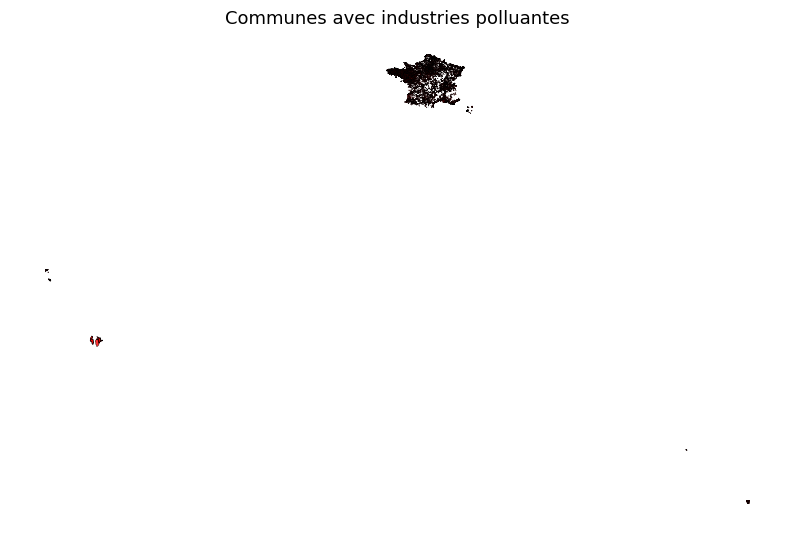

In [ ]:
import matplotlib.pyplot as plt


df = df.to_crs(epsg=4326)

# On filtre les communes présentes dans la table des industries polluantes
communes_polluantes = df[df["code_insee"].isin(industries_polluantes["code_insee"])]

# Carte
ax = communes_polluantes.plot(
    color="red",        # couleur de remplissage
    edgecolor="black",  # bordure noire
    linewidth=0.3,
    figsize=(10, 10),
    alpha=0.8
)

plt.title("Communes avec industries polluantes", fontsize=13)
plt.axis("off")
plt.show()



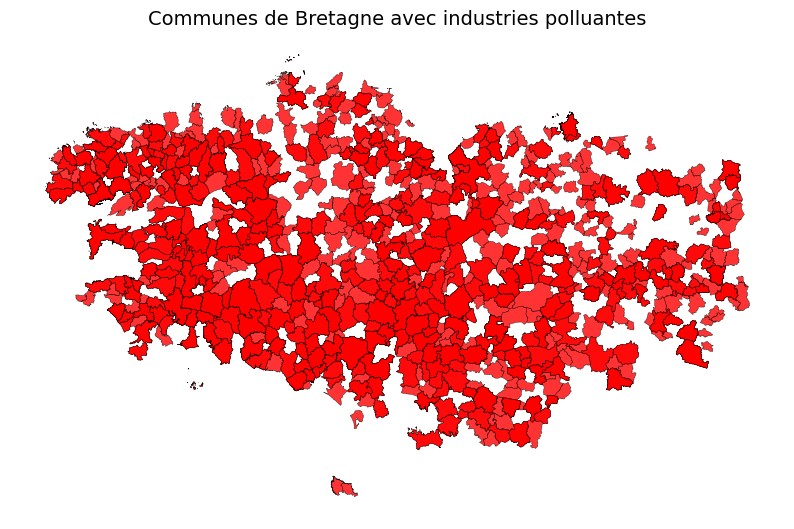

In [ ]:
# on filtre le GeoDataFrame pour ne garder que les communes de Bretagne (code_region = 53.0)
df_bretagne = df[df["code_region"] == 53.0]

# puis on filtre celles avec industries polluantes
communes_polluantes_bretagne = df_bretagne[df_bretagne["code_insee"].isin(industries_polluantes["code_insee"])]

# Carte
import matplotlib.pyplot as plt

ax = communes_polluantes_bretagne.plot(
    color="red",
    edgecolor="black",
    linewidth=0.3,
    figsize=(10, 10),
    alpha=0.8
)

plt.title("Communes de Bretagne avec industries polluantes", fontsize=14)
plt.axis("off")
plt.show()
